In [1]:
import gzip
import numpy as np

In [2]:
def load_data():    # 读取到npArray, 每维是一个28*28, 0~255取值的数组。
    with gzip.open('../data/train-images-idx3-ubyte.gz', 'rb') as f:
        train_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)
    with gzip.open('../data/train-labels-idx1-ubyte.gz', 'rb') as f:
        train_labels = np.frombuffer(f.read(), np.uint8, offset=8)
    with gzip.open('../data/t10k-images-idx3-ubyte.gz', 'rb') as f:
        test_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)
    with gzip.open('../data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
        test_labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_data()

In [3]:
# 对图像二值化，阈值取127
train_images = np.where(train_images > 127, 1, 0)
test_images = np.where(test_images > 127, 1, 0)

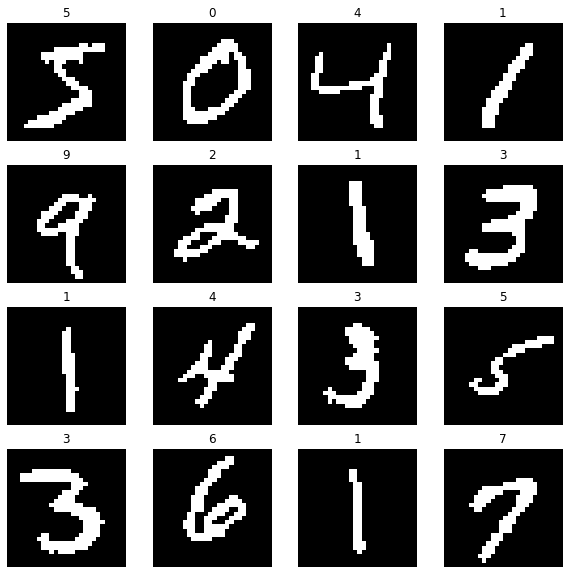

In [4]:
# 可视化一部分数据检验解析正确性
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    axs[i//4, i%4].imshow(train_images[i].reshape(28, 28), cmap='gray')
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].set_title(train_labels[i])
plt.show()

In [5]:
# 统计每个数字的频率, pw[i]=ln(p(w_i))
# 取对数防下溢出
pw = [0] * 10
for i in range(len(train_labels)):
    pw[train_labels[i]] += 1
for i in range(10):
    pw[i] = np.log(pw[i]/len(train_labels))

In [6]:
# 数据按类别归类到数组
num_images = [[] for i in range(10)]
for i in range(len(train_labels)):
    num_images[train_labels[i]].append(train_images[i])

In [7]:
# 计算每个类每个像素为白色的概率。num_images_p[i][k] = p'(x_k|w_i)【平滑过的p】
num_images_p = []
for i in range(10):             # 对每个类
    w = num_images[i]
    white_count = np.zeros(28*28, dtype = np.float32)
    for k in range(len(w)):     # 二值化后求和即得1的个数
        white_count += w[k]
    w = len(w)
    for k in range(28*28):    # 频率
        # 之后要取对数。所以这里防止log0用拉普拉斯平滑
        white_count[k] = (white_count[k]+1)/(w+10)
    num_images_p.append(white_count)

In [8]:
# 对输入的二值化28*28的图片用贝叶斯估计计算属于每个类的概率
def likely(img):
    likely = []                     # 属于数字i的“概率”
    for w in range(10):             # 对每类
        p = 0
        nump = num_images_p[w]
        for i in range(28*28):
            p = p + np.log(nump[i] if img[i]==1 else (1-nump[i]))
        likely.append(pw[w] + p)
    return likely

In [9]:
def test():
    right = 0
    error = []
    for i in range(len(test_images)):
        res = np.argmax(likely(test_images[i]))
        if res==test_labels[i]:
            right = right + 1
        else:
            error.append(i)
    print("accuracy: ",right/len(test_labels))
    return error

In [10]:
errors = test() # 在测试集上统计正确率

accuracy:  0.8426


In [11]:
with open('result.csv','w',encoding='utf-8') as f:
    f.write("id\tactual\tpredicted\n")
    for i in range(len(test_images)):
        res = np.argmax(likely(test_images[i]))
        f.write(f"{i}\t{test_labels[i]}\t{res}\n")
print("result saved!")

result saved!
